# Culvert Design using FHWA HDS5

Planning software such as SWMM5, XPSWMM InfoWorks ICM are great for modeling complicated system, with enough calibration data, we can build models that can predict the system performance with high confidence. The critical part of this process is calibrating key parameters.

However, when it comes to design problems or modeling systems without good calibration data, modelers can no long calibrate the model using observed data. For such situations, a responsible modeler will review established engineering publications and build simpler models to verify the more complicated models.

Culvert design is a great example, [FWHA HDS5 ](https://www.fhwa.dot.gov/engineering/hydraulics/pubs/12026/hif12026.pdf) is a great resource for sizing culvert, it listed easy to use method for calculating headwater, velocity, etc. 

With the help of the [HY-8 Culvert Hydraulic Analysis Program](https://www.fhwa.dot.gov/engineering/hydraulics/software/hy8/), a modeler can quickly get the performance curve, which can then be used as a "calibration" source when building more complicated models.




# Culvert in SWMM5

[SWMM Reference Manual Volume II—Hydraulics ](https://nepis.epa.gov/Exe/ZyPURL.cgi?Dockey=P100S9AS.txt) covers the culvert calculations in SWMM5 in details.

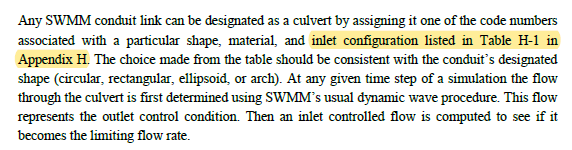

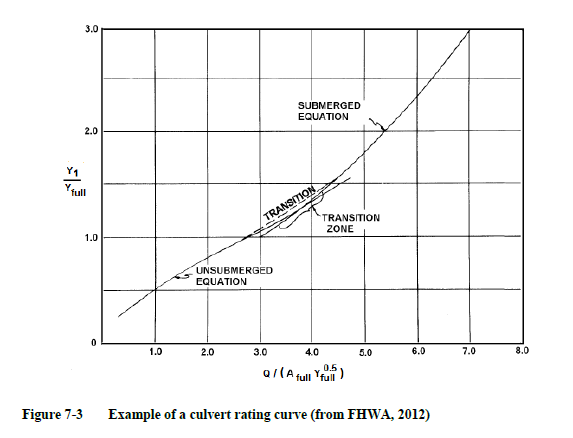

To be confident about SWMM5 is doing the right thing, I'll need to make sure the culvert performance curve generated using HY8 is similar to the one SWMM5 generates and they shoud be within 10% as HDS5 states.
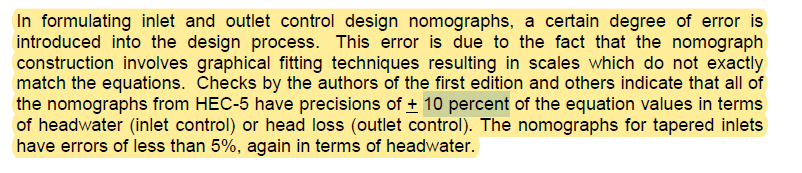

# Design Problem


HDS5 has the following example, 
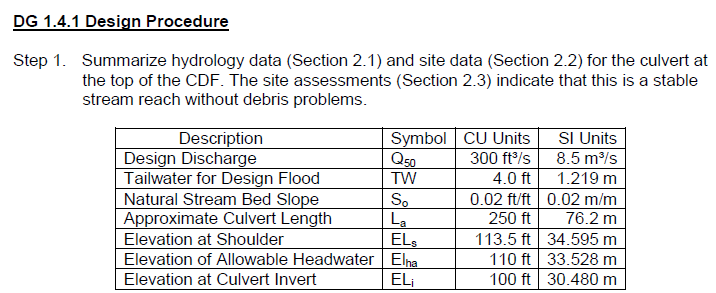


The results,

**54" RCP El hi=108.0ft, V0=15.3ft/s**


Let's go through that using the nomograph, HY8 and SWMM5

## HY-8

Example: 54" RCP El hi=108.0ft, V0=15.3ft/s

HY-8: El=108.61ft, v0=14.88 ft/s, within 1% difference.

The model is saved to : **./data/hds5_example.hy8**


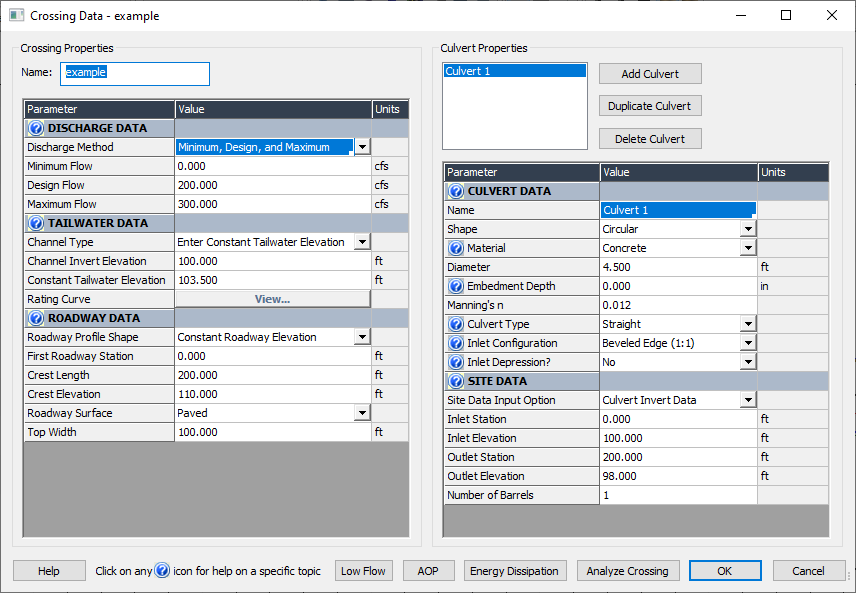

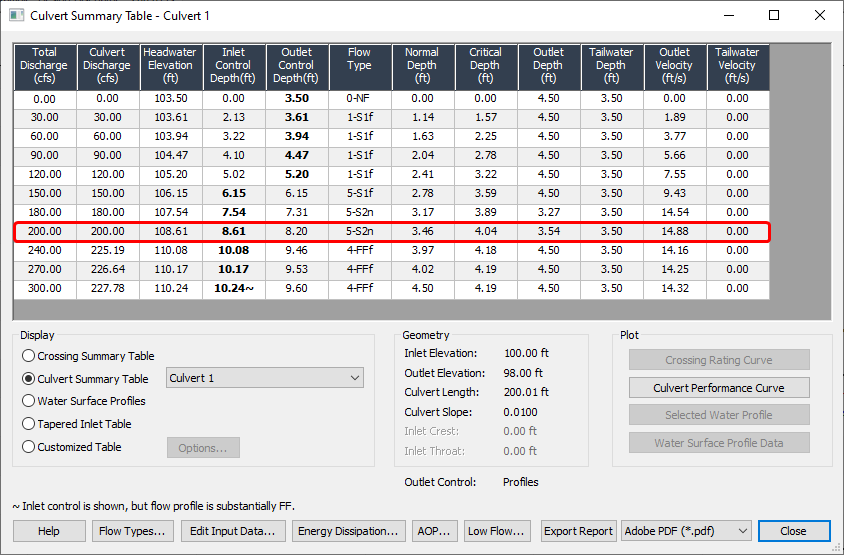

## Nomogrpah
For concrete pipes we'll use Nomographs chart 1B for inlet control, and chart 5B for outlet control.

Inlet control:

El = 4.5\*2.5=8.8ft


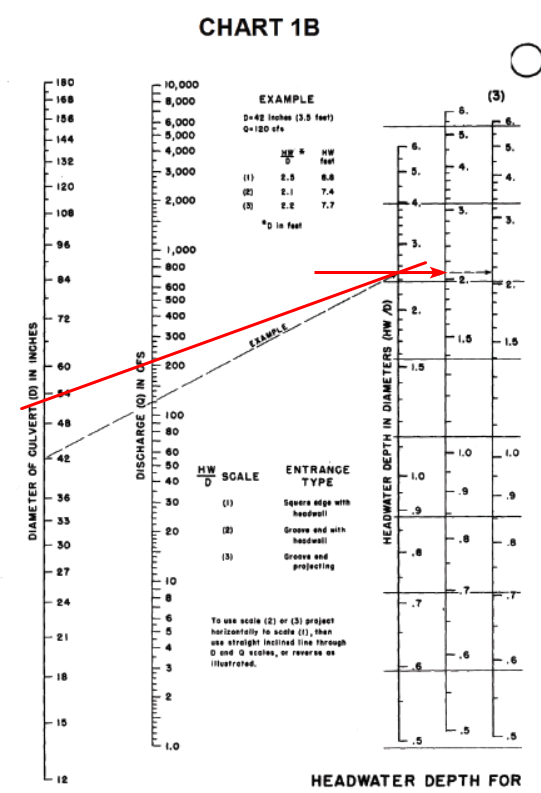

Instead of the 8.2 I got from HY8, I got 5ft for head water from this nomograph.


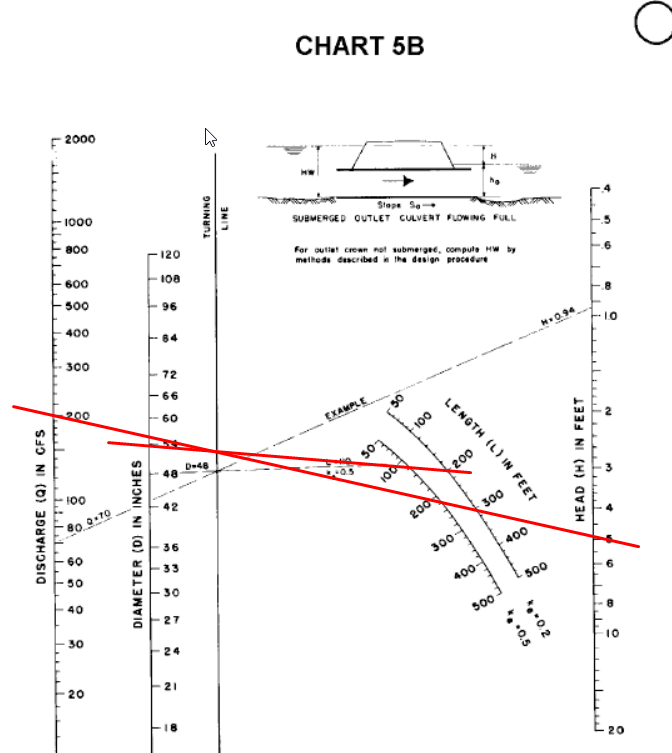

# Performance Curve

HY8 gives the performance curve for the culvert. The table is saved to **./data/hy8_performance_curve.csv**

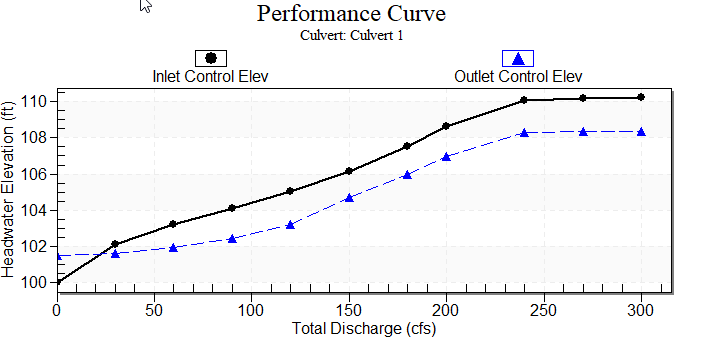

The same data is plotted from the csv file below.

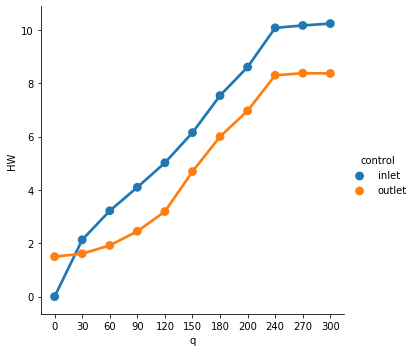

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hy8_performance_curve.csv"

df = pd.read_csv(f)
df_hy8_melt = df.melt('q', var_name='control',  value_name='HW')
g = sns.factorplot(x="q", y="HW", hue='control', data=df_hy8_melt)
plt.show()

## SWMM5 Model

A SWMM5 model is created to compare the performance curve.

Model: **./data/hds5_example.inp**

- For the culvert, don't set any losses, entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 0 - 300 cfs in 6 hours.
- The depth vs total inflow in node 54RCP_2 should give the performance curve
- added 3.5ft tail water at outlet
- Had to use a hotstart file to get the starting level correct

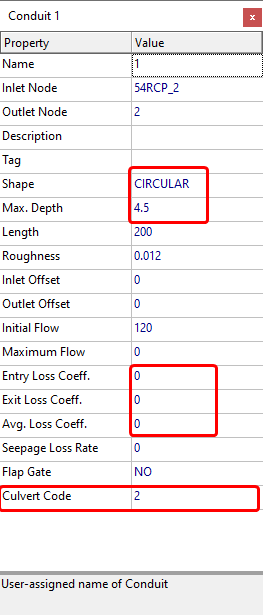

SWMM5 gives an answer of 7.92 ft for headwater depth, within 10% to HY8 result of 8.61ft.

A few things should be noted,

- SWMM5 doesn't use the entrance/exit loss directly, also there is a single straight line water level. So the HGL will looks very different from the HGL from  HY8
- It is not recommended to divide the culvert into smaller pieces to more accurately account for the water surface, because the way the HDS5 calculation is implemented in SWMM5, the goal is not to accurately get the water surface right, the goal is to get the inlet headwater right. See this [thread](https://www.openswmm.org/Topic/9038/culvert-inlet-loss-comparing-hy-8-to-swmm) for more details.


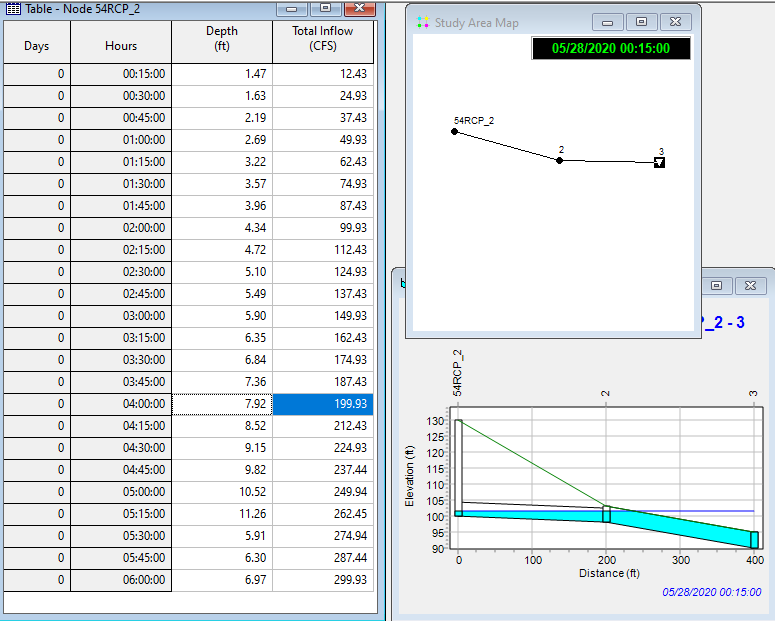

Profile in HY8

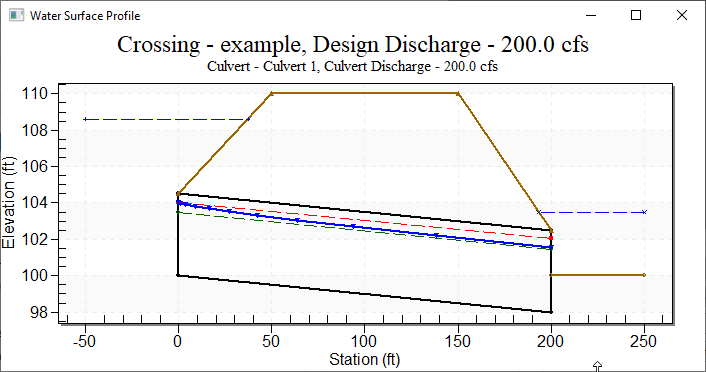

## Performance Curve : SWMM5 vs HY8

Using the code blocks below, I was able to compare the results.

In [9]:
from swmm.output import output as smo
import pandas as pd
import datetime
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()
    

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_node(out_path, node_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, 0))

    # get the time sereis from the out file
    depth = smo.getnodeseries(handle, node_index, smo.NodeAttribute.INVERT_DEPTH, 0, num_steps)
    q = smo.getnodeseries(handle, node_index, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'swmm5': depth, 'q': q}, index=timestep)
    return df


In [10]:
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hds5_example.inp"
run(f)
out_path = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hds5_example.out"
df_swmm = extract_node(out_path, 0)


... SWMM Version 5.3.0.dev0
... Run Complete54RCP_2


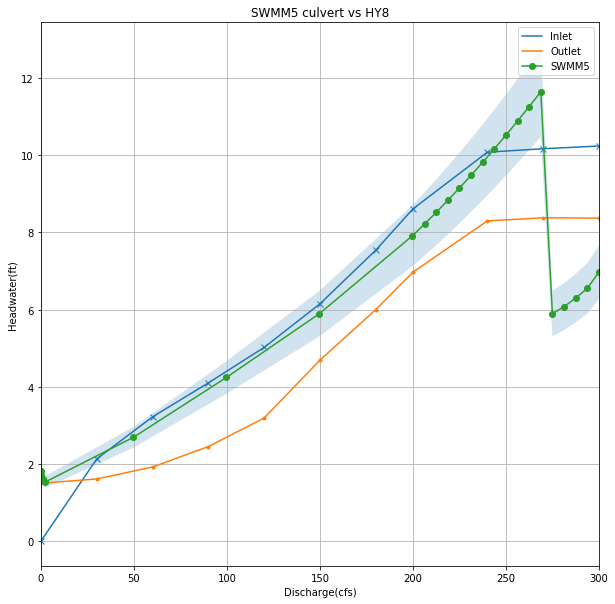

In [11]:

ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
ax = df_swmm.plot(x='q', y='swmm5', label='SWMM5', style='o-', ax=ax)
ax.fill_between(df_swmm['q'], df_swmm['swmm5']*0.9, df_swmm['swmm5']*1.1, alpha=0.2)
plt.xlabel('Discharge(cfs)')
plt.ylabel('Headwater(ft)')
plt.title('SWMM5 culvert vs HY8')
plt.grid(True)
plt.show()

The comparison is shown above,
- X is the discharge, Y is the head water depth
- the green line is swmm5 results
- the shaded area is the 90-110% for the swmm5 simulated curve
- the orange is the inlet curve
- the blue is the outlet curve

The conclusions,
- the culvert performance curve is the higher of the inlet/outlet curve
- SWMM5 correctly used the inlet control at very low flows, and correctly switched the outlet solutions
- For most part, SWMM5 results are within 10% of the HY8 results.
